In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

# Hyperparameters


In [4]:
COLUMNS_TO_KEEP = [
    "direct_rad:W",
    "clear_sky_rad:W",
    "diffuse_rad:W",
    # "direct_rad_1h:J",  # We also have a 0.959952 correlation between this and direct rad. But quite a lot of the others also do with each other, may be worth to keep?
    "is_in_shadow:idx",
    "clear_sky_energy_1h:J",
    "diffuse_rad_1h:J",
    "is_day:idx",
    "sun_elevation:d",
    # Correlation to final output <0.44
    # "ceiling_height_agl:m",
    # "effective_cloud_cover:p",
    # "visibility:m",
    # 'total_cloud_cover:p',
    # 'air_density_2m:kgm3',
    # 'wind_speed_v_10m:ms',
    # 'dew_point_2m:K',
    # 'wind_speed_u_10m:ms',
    # 't_1000hPa:K',
    # 'absolute_humidity_2m:gm3',
    # 'snow_water:kgm2',
    # 'relative_humidity_1000hPa:p',
    # 'fresh_snow_24h:cm',
    # 'cloud_base_agl:m',
    # 'fresh_snow_12h:cm',
    # 'snow_depth:cm',
    # 'dew_or_rime:idx',
    # 'fresh_snow_6h:cm',
    # 'super_cooled_liquid_water:kgm2',
    # 'fresh_snow_3h:cm',
    # 'rain_water:kgm2',
    # 'precip_type_5min:idx',
    # 'precip_5min:mm',
    # 'fresh_snow_1h:cm',
    # 'sun_azimuth:d',
    # 'msl_pressure:hPa',
    # 'pressure_100m:hPa',
    # 'pressure_50m:hPa',
    # 'sfc_pressure:hPa',
    # 'prob_rime:p',
    # 'wind_speed_10m:ms',
    # 'elevation:m',
    # 'snow_density:kgm3',
    # 'snow_drift:idx',
    # 'snow_melt_10min:mm',
    # 'wind_speed_w_1000hPa:ms',
    # "date_calc", something wrong with this column
    "pv_measurement",
]
LEARNING_RATE = 0.0001
NUM_EPOCHS = 10
BATCH_SIZE = 32
NUM_FEATURES = len(COLUMNS_TO_KEEP) - 1  # -1 because pv_measurement is the target
FEATURE_SIZE = 4  # 7 days of hourly data
WEIGHT_DECAY = 0 #0.01
SEQUENCE_LENGTH = 14*24

# Neural net


In [5]:
# Create a custom dataset and model

class BasicCNNDataset(Dataset):
    def __init__(self, feature_array, target_array, sequence_length):
        self.data = feature_array
        self.targets = target_array
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        return self.data[idx : idx + self.sequence_length], self.targets[idx : idx + self.sequence_length]


class BasicCNN(nn.Module):
    def __init__(self, num_features, sequence_length, conv1_hidden = 32, conv2_hidden=32, conv3_hidden = 16, conv4_hidden = 4):
        super(BasicCNN, self).__init__()
        self.conv=nn.Sequential(
            nn.Conv1d(num_features, conv1_hidden, kernel_size=11, stride=1, padding="same"),
            nn.Conv1d(conv1_hidden, conv2_hidden, kernel_size=9, stride=1, padding="same"),
            nn.Dropout(0.1),
            nn.Conv1d(conv2_hidden, conv3_hidden, kernel_size=7, stride=1, padding="same"),
            nn.Conv1d(conv3_hidden, conv4_hidden, kernel_size=3, stride=1, padding="same"),
            nn.Dropout(0.1),
            nn.Conv1d(conv4_hidden, 1, kernel_size=3, stride=1, padding="same"),
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # channels (features) must be in the second dimension
        x = self.conv(x)
        x = torch.squeeze(x)
        x = nn.functional.relu(x)
        return x



# Load dataset


Important note is that I concatenate the forecast and the observed training data, as they may work similarily. This is an important assumption

In [6]:
# Load and process data

location = "A"
def load_and_process_data(location):
    df_data = pd.read_parquet(f"data/{location}/X_train_observed.parquet")
    df_forecast = pd.read_parquet(f"data/{location}/X_train_estimated.parquet")
    df_target = pd.read_parquet(f"data/{location}/train_targets.parquet")

    # concat data and forecast. # NOTE: IMPORTANT ASSUMPTION. MAY BE DANGEROUS
    df_concat = pd.concat((df_data, df_forecast))

    # Merge the datasets
    df_merged = pd.merge(
        df_concat, df_target, left_on="date_forecast", right_on="time", how="inner"
    )

    # Downsampling the dataframe to hourly intervals
    df_merged = df_merged.resample('H', on="date_forecast").mean()
    # df_merged = df_merged.dropna(how='all').reset_index(drop=True)  # TODO: Reevaluate if we need this

    # Filter columns
    df_merged = df_merged[COLUMNS_TO_KEEP]

    # Set all NaN values to 0
    df_merged.fillna(0, inplace=True)

    # Split to X and Y
    X = df_merged.drop("pv_measurement", axis=1)
    y = df_merged["pv_measurement"]

    # Normalize the input features
    scaler = MinMaxScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    return X, y

In [7]:
# Create and split datasets
prediction_length = 24*30  # 24 hours for 30 days

X, y = load_and_process_data(location)

# split into train and test:
train_test_ratio = 0.8
X_train, X_test = X[:round(len(X)*train_test_ratio)], X[round(len(X)*train_test_ratio):]
y_train, y_test = y[:round(len(X)*train_test_ratio)], y[round(len(X)*train_test_ratio):]


train_dataset = BasicCNNDataset(X_train.to_numpy(), y_train.to_numpy(), prediction_length)
val_dataset = BasicCNNDataset(X_test.to_numpy(), y_test.to_numpy(), prediction_length)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


# Training Loop


In [8]:
import matplotlib.pyplot as plt
def plot_losses(losses):
    # Create an array to represent the number of epochs or iterations
    # This assumes that you have the same number of losses as epochs or iterations
    epochs = range(1, len(losses) + 1)

    # Create the plot
    plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
    plt.plot(epochs, losses, label='Validation Loss', marker='o', linestyle='-', color='b')
    plt.title('Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.grid(True)

    # Display the plot (if you're using Jupyter Notebook, this step might be optional)
    plt.show()

In [9]:
def train_model(model, train_loader, val_loader):
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    val_losses = []

    for epoch in range(NUM_EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # Evaluate the model on the validation set
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()


        # Average validation loss
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(
            f"Epoch {epoch + 1}/{NUM_EPOCHS}, Training Loss: {loss.item()}, Validation Loss: {val_loss}"
        )
        plot_losses(val_losses)

    print("Training complete!")

In [10]:
from torchsummary import summary
def save_model(model, location):
    filename = f"model_location_{location}.pt"
    torch.save(model.state_dict(), filename)
    print(f"Model saved as {filename}")


model = BasicCNN(NUM_FEATURES, prediction_length)
summary(model, input_size=(prediction_length, NUM_FEATURES))
# train_model(model, train_loader, val_loader)
# save_model(model, location)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 720]           2,848
            Conv1d-2              [-1, 32, 720]           9,248
           Dropout-3              [-1, 32, 720]               0
            Conv1d-4              [-1, 16, 720]           3,600
            Conv1d-5               [-1, 4, 720]             196
           Dropout-6               [-1, 4, 720]               0
            Conv1d-7               [-1, 1, 720]              13
Total params: 15,905
Trainable params: 15,905
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.66
Params size (MB): 0.06
Estimated Total Size (MB): 0.75
----------------------------------------------------------------


# Evaluate results locally
Evaluate on the last 720 hours of our given dataset.

In [11]:
def load_model(location):
    model = BasicCNN(NUM_FEATURES, prediction_length)
    model.load_state_dict(torch.load(f"model_location_{location}.pt"))
    model.eval()
    return model

def make_predictions(model, df_test):
    
    # Ensure the index is a datetime
    df_test['date_forecast'] = pd.to_datetime(df_test['date_forecast'])

    # Downsampling the dataframe to hourly intervals
    df_test = df_test.resample('H', on="date_forecast").mean()
    df_test = df_test.dropna(how='all').reset_index(drop=True)

    # Filter columns
    df_test = df_test[COLUMNS_TO_KEEP[:-1]]

    # Set all NaN values to 0
    df_test.fillna(0, inplace=True)


    # Normalize the input features
    scaler = MinMaxScaler()
    X_test = pd.DataFrame(scaler.fit_transform(df_test), columns=df_test.columns)
    
    # Create one long input sequence with all our data
    test_tensor = torch.from_numpy(X_test.to_numpy())
    # Make predictions
    with torch.no_grad():
        predictions = model(test_tensor.unsqueeze(0))
        predictions = predictions.numpy()
    return predictions

Mean average error:  273.16894334930845


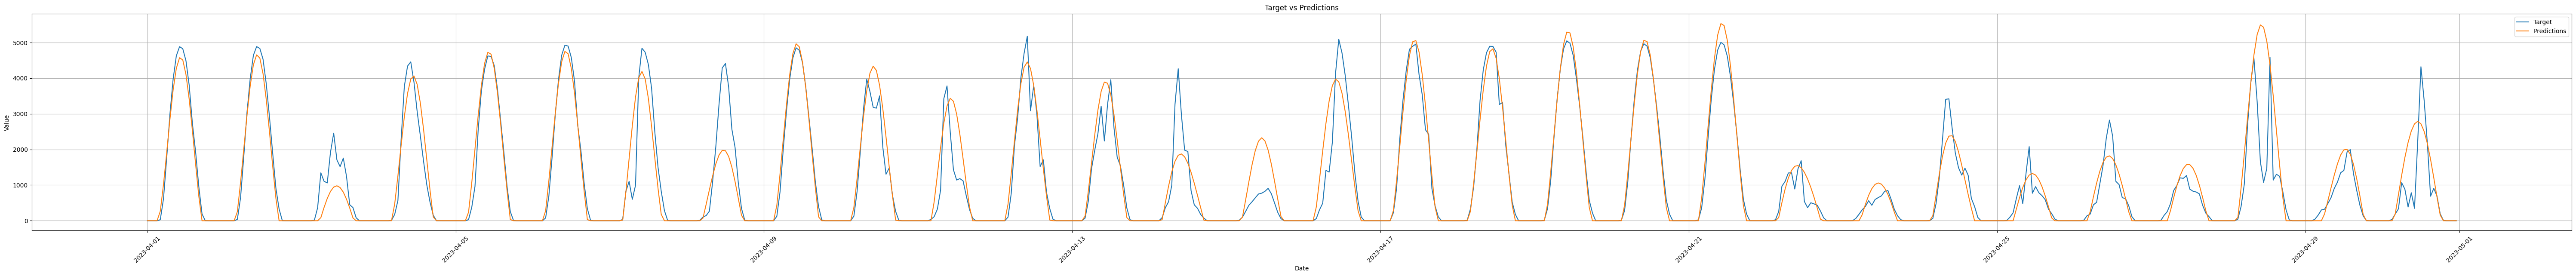

Mean average error:  50.04899757187068


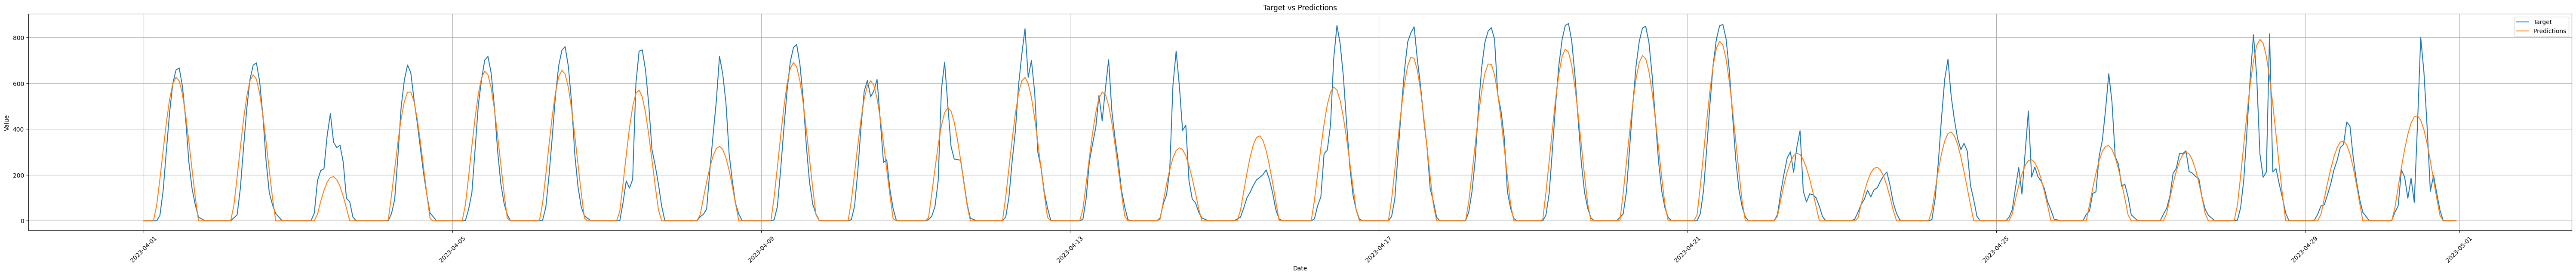

Mean average error:  59.79240256073741


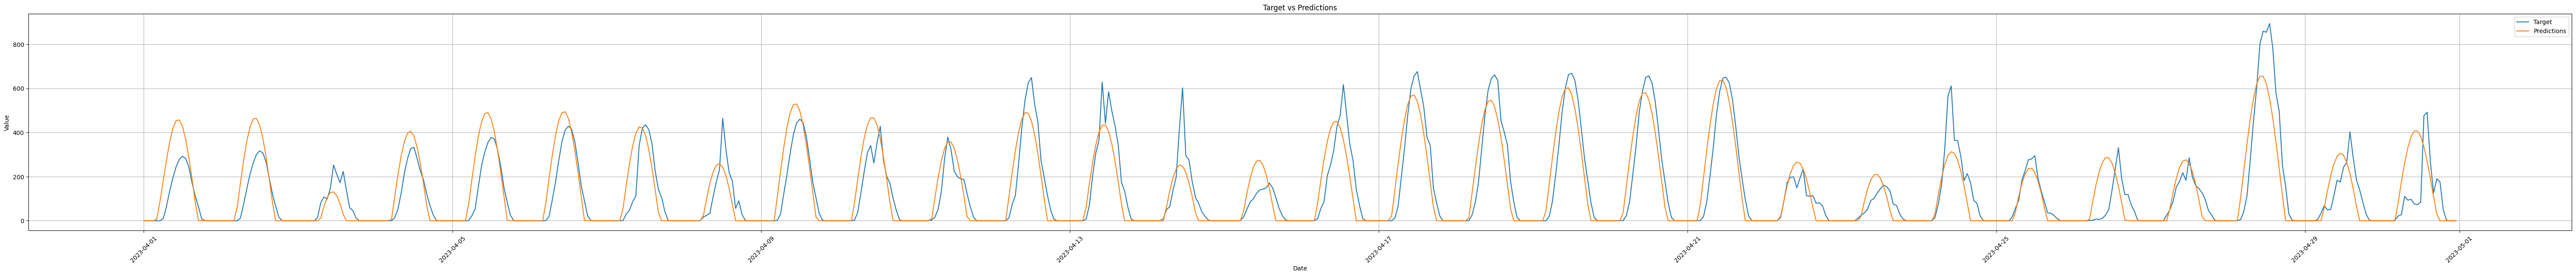

In [34]:
# Test the model on the final 720 data points and plot.
# location = "C"
def evaluate_locally(location):
    data = pd.read_parquet(f"data/{location}/X_train_estimated.parquet").tail(720*4)
    model = load_model(location)
    target = pd.read_parquet(f"data/{location}/train_targets.parquet").tail(720)["pv_measurement"].to_numpy()

    predictions = make_predictions(model, data)
    mae = mean_absolute_error(target, predictions)
    print("Mean average error: ", mae)

    # Plotting
    plt.figure(figsize=(60,6))
    plt.plot(data['date_forecast'][::4], target, label="Target")
    plt.plot(data['date_forecast'][::4], predictions, label="Predictions")
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Target vs Predictions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()


for loc in ["A", "B", "C"]:
    evaluate_locally(loc) 

# Submit to CSV for Kaggle

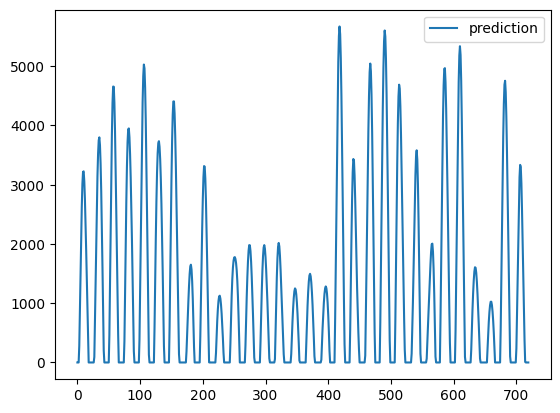

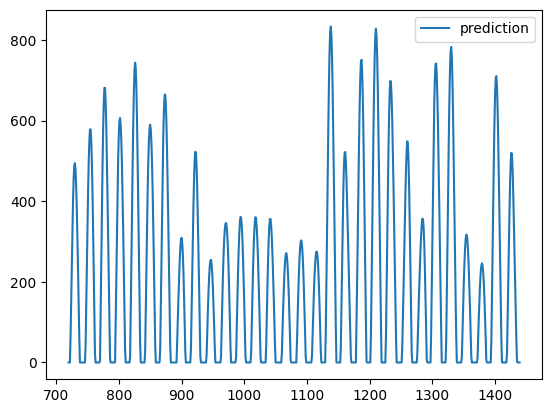

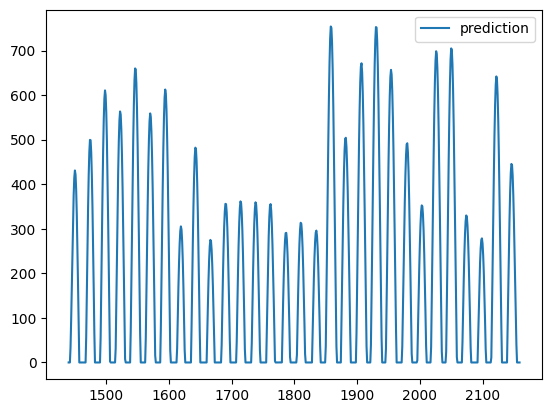

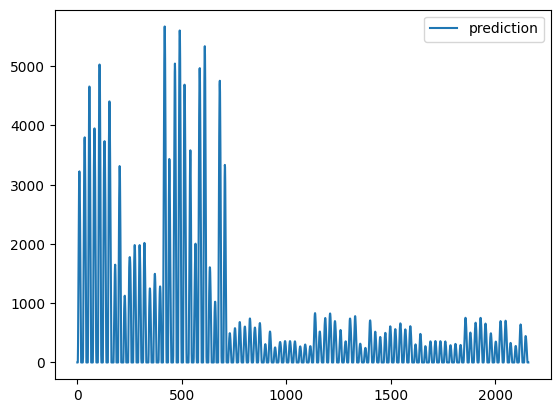

In [39]:
# Predict for kaggle

def submit_to_csv():

    # Read the Kaggle test.csv to get the location and ids
    df_submission = pd.read_csv("data/test.csv")
    df_submission["prediction"] = df_submission["prediction"].astype("float32")

    locations = ["A", "B", "C"]

    # Iterate over the locations and fill in the predictions
    for loc in locations:
        # Load forecasted weather data for testing for the current location
        df_loc = pd.read_parquet(f"data/{loc}/X_test_estimated.parquet")
        # Load model
        model = load_model(loc)
        preds = make_predictions(model, df_loc)
        # Assign the predictions to df_submission for the current location
        mask = df_submission["location"] == loc
        df_submission.loc[mask, "prediction"] = preds
        df_submission[mask].drop(columns="id").plot()

    # Save the results to a new submission file
    df_submission[["id", "prediction"]].to_csv("sample_kaggle_submission.csv", index=False)
    
    df_submission.drop(columns="id").plot()

submit_to_csv()